In [45]:
# Data science toolkit
library(tidyverse)

# Modeling
library(caret)

# Correlation
library(corrplot)

In [46]:
# Load dataset
raw_data <- read.csv('../Data/iris.csv')

# Output data dimensionos
cat(paste0('Dimensions of dataset:\nrows: ',dim(raw_data)[1],'\ncolumns: ',dim(raw_data)[2]))

# Peak at dataset
head(raw_data)

Dimensions of dataset:
rows: 150
columns: 5

sepal_length,sepal_width,petal_length,petal_width,species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


### Exploring the distribution of class lables given top 2 principal componenets
#### Classes are clearly linearly seperable 

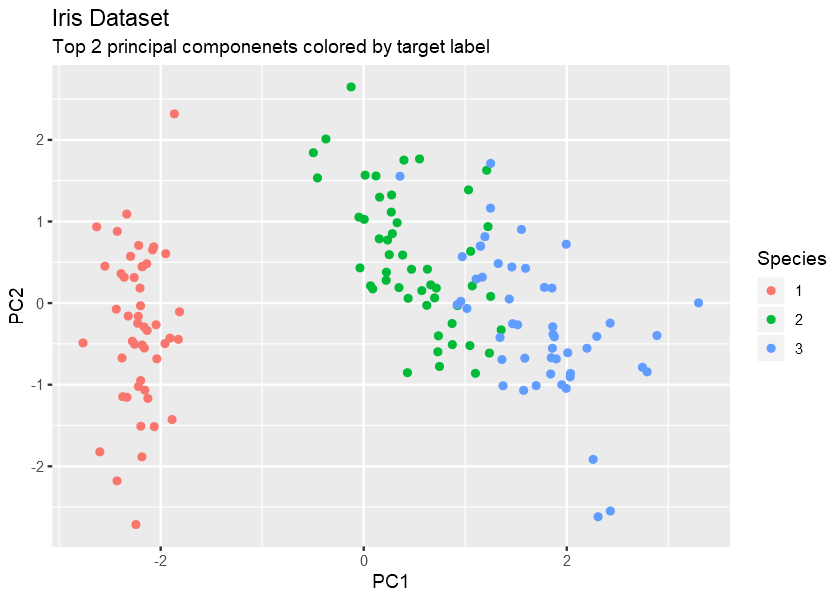

In [47]:
# Perform PCA
pca_data <- prcomp(raw_data[,1:4],center=T,scale=T)

# Append target labels
pca_target <- data.frame(cbind(pca_data$x,SPECIES=raw_data$species))

# Set plot dimensions
options(repr.plot.width=7,repr.plot.height=5)

# Chart results
ggplot(pca_target,aes(x=PC1,y=PC2,color=as.factor(SPECIES))) + 
    geom_point() +
    labs(title='Iris Dataset',
         subtitle='Top 2 principal componenets colored by target label',
         color='Species')

### Investigating most influencial features
#### Recursive feature elimination (RFE), build linear model with 1-n features and monitor performance at each level


Recursive feature selection

Outer resampling method: Cross-Validated (5 fold) 

Resampling performance over subset size:

 Variables Accuracy Kappa AccuracySD KappaSD Selected
         1   0.9133  0.87    0.02981 0.04472         
         2   0.9533  0.93    0.03801 0.05701         
         3   0.9467  0.92    0.02981 0.04472         
         4   0.9600  0.94    0.03651 0.05477        *

The top 4 variables (out of 4):
   petal_width, petal_length, sepal_length, sepal_width



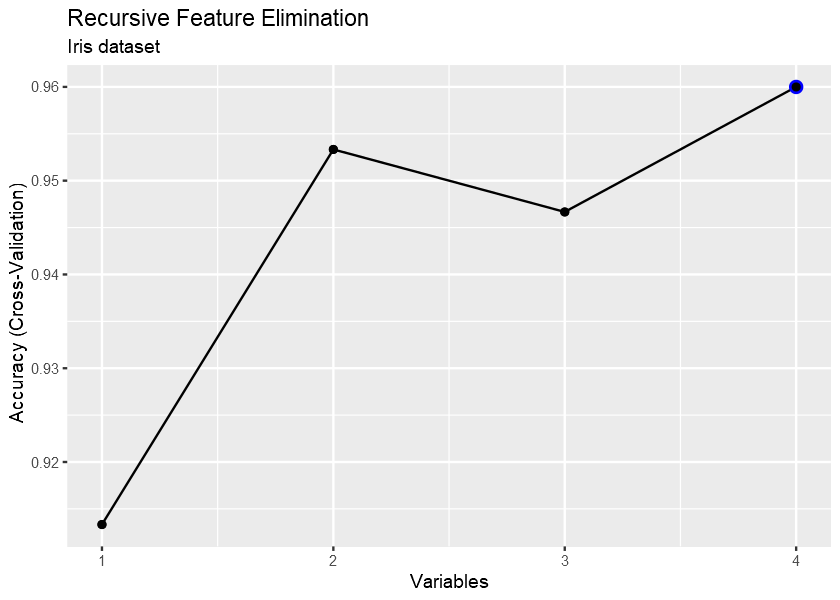

In [48]:
# Configure cross-validation settings
control <- rfeControl(functions=rfFuncs,method='cv',number=5)

# Run RFE
results <- rfe(raw_data[,1:4],raw_data[,5],sizes=c(1:4),rfeControl=control)

# Print results
print(results)

# Plot results
ggplot(results) +
    geom_point() +
    labs(title='Recursive Feature Elimination',
         subtitle='Iris dataset')

### Data partitioning
#### Splitting data into train/validation partitions

In [49]:
# Split training and validation
set.seed(7)
validation_idx <- createDataPartition(raw_data$species,p=0.70,list=FALSE)
train <- raw_data[validation_idx,]
validation <- raw_data[-validation_idx,]

### Perform model comparison
#### Configure training options and iterate through group of models
##### Additional models for the caret library: https://topepo.github.io/caret/available-models.html

In [57]:
# Test options and evaluation metric
trainCtrl <- trainControl(method='repeatedcv',number=5,repeats=3,classProbs=TRUE)
metric <- 'Accuracy'

# Prepare list of algorithms
algorithm_list <- c(# Rule based
                    'rpart',
                    'rf',
                    # Linear
                    'lda',
                    'svmLinear',
                    # Instance based
                    'knn',
                    # Kernelized
                    'svmRadial')

# Prepare vector for trained models
initial_models <- as.list(vector(length=length(algorithm_list)))

# Iterate through algorithms and train models
for(i in 1:length(algorithm_list)){
    # Random seed for reproducibility
    set.seed(7)
    
    # Model training
    initial_models[[i]] <- train(x=train[,1:4],y=train[,5],
                                 method=algorithm_list[i],
                                 metric=metric,
                                 #preProcess=c('scale'),
                                 trControl=trainCtrl)
    
    # Print model results
    cat('-----------------------------------------------------------------------\n')
    print(initial_models[[i]])
}

-----------------------------------------------------------------------
CART 

105 samples
  4 predictor
  3 classes: 'setosa', 'versicolor', 'virginica' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 84, 84, 84, 84, 84, 84, ... 
Resampling results across tuning parameters:

  cp         Accuracy   Kappa    
  0.0000000  0.9333333  0.9000000
  0.4285714  0.7206349  0.5809524
  0.5000000  0.3333333  0.0000000

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.
-----------------------------------------------------------------------
Random Forest 

105 samples
  4 predictor
  3 classes: 'setosa', 'versicolor', 'virginica' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 84, 84, 84, 84, 84, 84, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.9333333  0.9000000
  3     0.9301587 

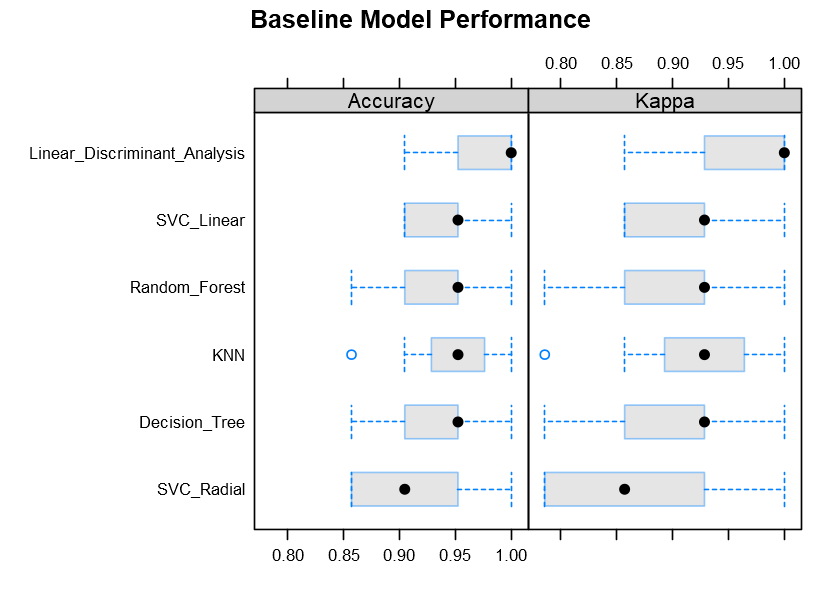

In [58]:
# Collect cross-validation results
initial_results <- resamples(list(Decision_Tree=initial_models[[1]],
                                  Random_Forest=initial_models[[2]],
                                  Linear_Discriminant_Analysis=initial_models[[3]],
                                  SVC_Linear=initial_models[[4]],
                                  KNN=initial_models[[5]],
                                  SVC_Radial=initial_models[[6]]))

# Model CV performance
bwplot(initial_results, labels=names(initial_results),
       horizontal=TRUE,
       par.settings=list(box.rectangle=list(fill="grey", alpha=0.4), strip.background=list(col="lightgrey")),
       main='Baseline Model Performance')

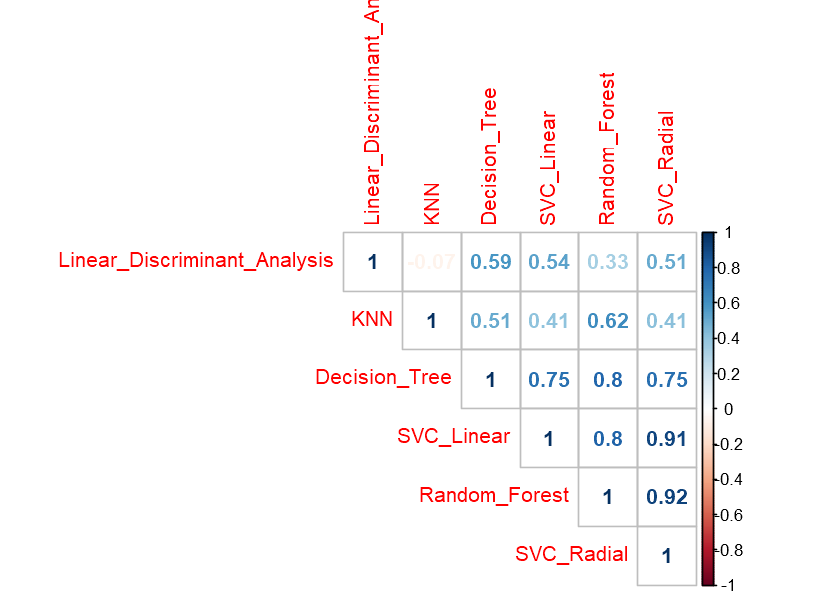

In [59]:
# Model correlation plot
corrplot(modelCor(initial_results), method='number', type='upper', order='hclust')

### Hyperparameter tuning
#### Experimental process to determine the optimal value for tunable parameters
##### This process could be run again with values centered around the optimal values shown from the first pass (e.g. SVM Radial C around 1 and sigma around 1.5)

Support Vector Machines with Radial Basis Function Kernel 

150 samples
  4 predictor
  3 classes: 'setosa', 'versicolor', 'virginica' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 120, 120, 120, 120, 120, 120, ... 
Resampling results across tuning parameters:

  C    sigma  Accuracy   Kappa    
  0.5  1.5    0.9511111  0.9266667
  0.5  2.0    0.9466667  0.9200000
  0.5  2.5    0.9488889  0.9233333
  1.0  1.5    0.9555556  0.9333333
  1.0  2.0    0.9511111  0.9266667
  1.0  2.5    0.9511111  0.9266667
  1.5  1.5    0.9533333  0.9300000
  1.5  2.0    0.9488889  0.9233333
  1.5  2.5    0.9466667  0.9200000
  2.0  1.5    0.9466667  0.9200000
  2.0  2.0    0.9488889  0.9233333
  2.0  2.5    0.9422222  0.9133333
  2.5  1.5    0.9444444  0.9166667
  2.5  2.0    0.9377778  0.9066667
  2.5  2.5    0.9444444  0.9166667
  3.0  1.5    0.9422222  0.9133333
  3.0  2.0    0.9444444  0.9166667
  3.0  2.5    0.9422222  0.9133333

Accuracy was used

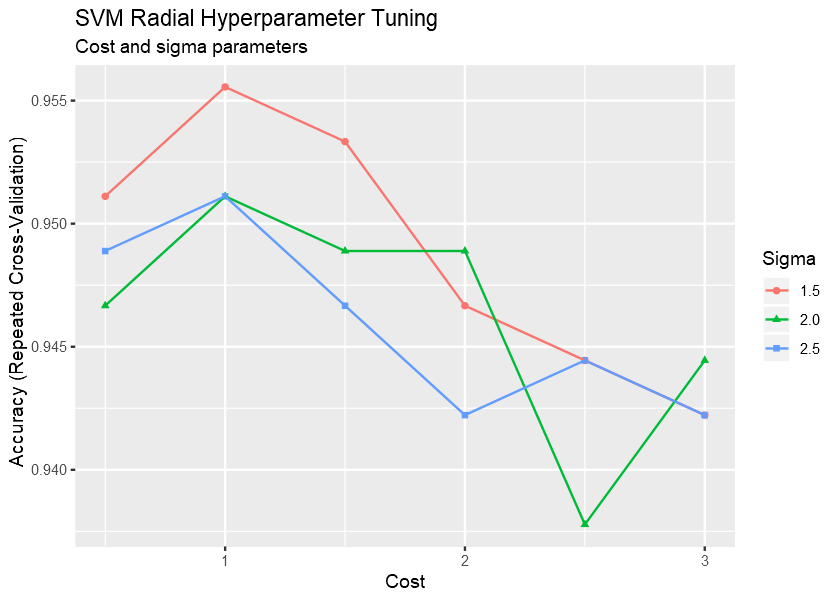

In [62]:
# SVC Radial
set.seed(7)
grid <- expand.grid(.C=seq(0.5,3,by=0.5),.sigma=seq(1.5,2.5,by=0.5))
tune.svcRad <- train(x=raw_data[,1:4],y=raw_data[,5],method="svmRadial",metric=metric,tuneGrid=grid,trControl=trainCtrl)
print(tune.svcRad)
ggplot(tune.svcRad) +
    labs(title='SVM Radial Hyperparameter Tuning',
         subtitle='Cost and sigma parameters')

Support Vector Machines with Linear Kernel 

150 samples
  4 predictor
  3 classes: 'setosa', 'versicolor', 'virginica' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 120, 120, 120, 120, 120, 120, ... 
Resampling results across tuning parameters:

  C    Accuracy   Kappa    
  0.5  0.9644444  0.9466667
  1.0  0.9644444  0.9466667
  1.5  0.9577778  0.9366667
  2.0  0.9711111  0.9566667
  2.5  0.9666667  0.9500000
  3.0  0.9600000  0.9400000

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was C = 2.


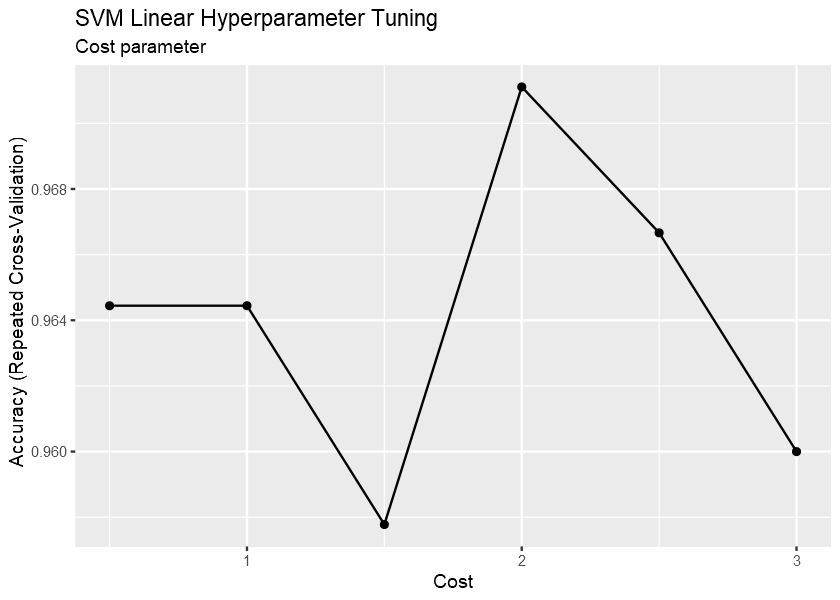

In [63]:
# SVC Linear
set.seed(7)
grid <- expand.grid(.C=seq(0.5,3,by=0.5))
tune.svcLin <- train(x=raw_data[,1:4],y=raw_data[,5],method="svmLinear",metric=metric,tuneGrid=grid,trControl=trainCtrl)
print(tune.svcLin)
ggplot(tune.svcLin) +
    labs(title='SVM Linear Hyperparameter Tuning',
         subtitle='Cost parameter')